# Supplementary: 3RC Fitting

## Package and Data

In [1]:
## editing system path to enable the load of the modified impedance.py with NLEIS toolbox
import os.path
import sys
current_dir = os.path.dirname(os.path.abspath('__file__'))

# Get the parent directory by moving up one level
parent_dir = os.path.dirname(current_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

In [2]:
### basic package

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import savgol_filter
from scipy import interpolate
from scipy.stats import linregress

import time
import matplotlib.patches as patches
import glob 

### NLEIS toolbox based on impedance.py

from nleis import nleis
from nleis.nleis_fitting import data_processing

from nleis import EISandNLEIS
from nleis import NLEISCustomCircuit
from nleis.visualization import plot_first,plot_second
from impedance.models.circuits import CustomCircuit

### formatting package

from tqdm import tqdm
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")




In [3]:
## definition of cost function
def cost_max_norm(data,model):
    Max = max(abs(data))
    data = data/Max
    model = model/Max
    sum1 = np.sum((data.real-model.real)**2)
    sum2 = np.sum((data.imag-model.imag)**2)
    return(sum1+sum2)

In [4]:
def EIS(ax1,Z1,f,initial_guess,circ_str_1,bounds = None, sequential = True,constants = None):

    circuit = CustomCircuit(circ_str_1,initial_guess=initial_guess,constants = constants)
    circuit.fit(f,Z1,bounds = bounds);
    Z1_fit = circuit.predict(f)
    p1 = circuit.parameters_
    conf = circuit.conf_
    plot_first(ax1, Z1, fmt='o')
    plot_first(ax1, Z1_fit, fmt='-o',lw=3)
    ax1.text(0.73, 0.15, '$COST_{1} = $'+'{:0.1e}'.format(cost_max_norm(Z1,Z1_fit)), horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes,size=16)
    ax1.legend(['Data','Model'],fontsize=16,loc='best')

    return Z1_fit,p1,conf

    

In [5]:
def table(p,name):
    print(name)
    header=['L0','R0','R1','C1','Q1']
    print(tabulate([p[0:5]],headers=header))
    header=['R2','C2','Q2']
    print(tabulate([p[5:8]],headers=header))
    header=['R3','Aw','t','C3','Q3']
    print(tabulate([p[8:13]],headers=header))
def R(p):
    return(p[2]+p[5]+p[8])
def sigma(p):
    return(np.sqrt(p[2]**2+p[5]**2+p[8]**2))    

In [6]:
def EIS_vis(p,f):
    circ_str_1 = 'p(R1,CPE1)'
    circ_str_2 = 'p(R2,CPE2)'
    circ_str_3 = 'p(R3-Wo1,CPE3)'
    circuit1 = CustomCircuit(circ_str_1,initial_guess=p[2:5])
    Z1 = circuit1.predict(f)
    circuit2 = CustomCircuit(circ_str_2,initial_guess=p[5:8])
    Z2 = circuit2.predict(f)   
    circuit3 = CustomCircuit(circ_str_3,initial_guess=p[8:13])

    Z3 = circuit3.predict(f)   
    fig,ax = plt.subplots()
    plot_first(ax, Z1, fmt='-o',lw=3)
    plot_first(ax, Z2, fmt='-o',lw=3)
    plot_first(ax, Z3, fmt='-o',lw=3)
    ax.legend(['RC1','RC2','RC3'],fontsize=16,loc='best')
    plt.show()


In [7]:
path ='data/' 

# Fresh Cell

In [8]:
i= 51
f_f=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_freq.txt').view(float)

Z1_f10=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_10_.txt').view(complex)
Z2_f10=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_10_.txt').view(complex)
mask =Z1_f10.imag<0
f10 = f_f[mask]
Z1_f10 =  Z1_f10[mask]
Z2_f10 =  Z2_f10[mask]

Z1_f30=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_30_.txt').view(complex)
Z2_f30=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_30_.txt').view(complex)
mask =Z1_f30.imag<0
f30 = f_f[mask]
Z1_f30 =  Z1_f30[mask]
Z2_f30 =  Z2_f30[mask]

Z1_f50=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_50_.txt').view(complex)
Z2_f50=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_50_.txt').view(complex)
mask =Z1_f50.imag<0
f50 = f_f[mask]
Z1_f50 =  Z1_f50[mask]
Z2_f50 =  Z2_f50[mask]

## Curve Fitting 

### 10%

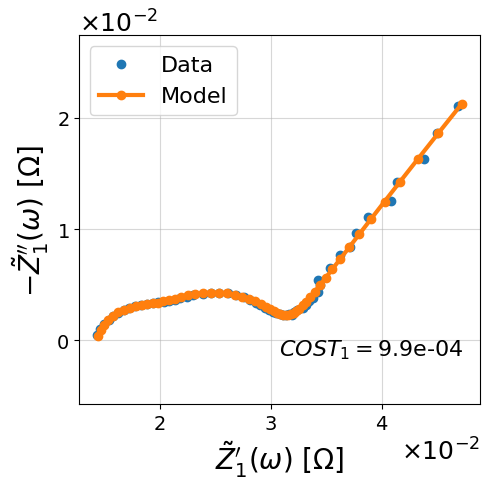

--- 0 mins 0.91 seconds ---


In [ ]:
start_time = time.time()
### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode

circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01/2;C1 = 10;Q1 = 1;
R2 = 0.01/2;C2 = 20;Q2=1;
R3 = 0;C3 = 100;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])

fig, ax = plt.subplots(figsize=(5,5))


Z1_fit_f_10p,p1_f_10p,conf_f_10p = EIS(ax,Z1_f10,f10,initial_guess,circ_str_1
                       ,bounds = None,)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [10]:
table(p1_f_10p,'Parameters Set')

Parameters Set
         L0         R0          R1        C1        Q1
-----------  ---------  ----------  --------  --------
1.37193e-07  0.0133025  0.00606866  0.306118  0.804919
       R2       C2        Q2
---------  -------  --------
0.0120007  3.60468  0.717002
        R3       Aw        t       C3        Q3
----------  -------  -------  -------  --------
0.00165304  1.25715  28000.4  212.106  0.753767


In [11]:
R(p1_f_10p)

0.01972239062957853

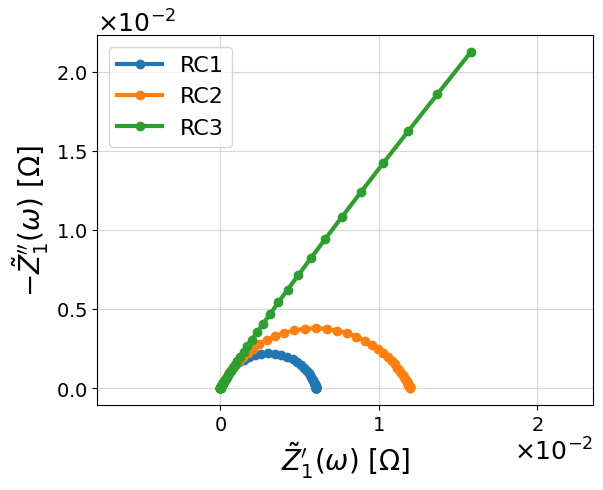

In [12]:
EIS_vis(p1_f_10p,f10)

### 30%

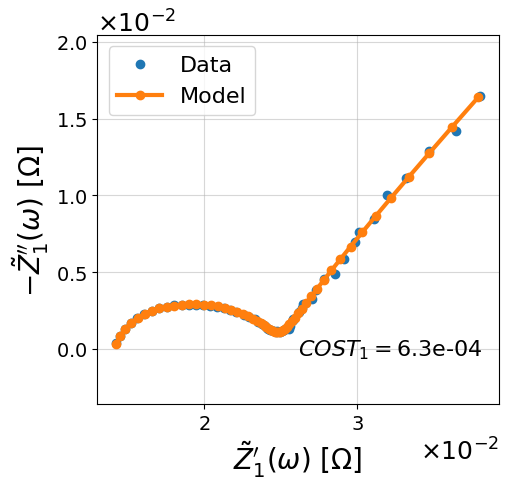

--- 0 mins 1.83 seconds ---


In [13]:
start_time = time.time()
### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.01;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])

fig, ax = plt.subplots(figsize=(5,5))

Z1_fit_f_30p,p1_f_30p,conf_f_30p = EIS(ax,Z1_f30,f30,initial_guess,circ_str_1
                       ,bounds = None,)
plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [14]:
table(p1_f_30p,'Parameters Set')

Parameters Set
         L0        R0          R1        C1        Q1
-----------  --------  ----------  --------  --------
1.45284e-07  0.013035  0.00375473  0.284254  0.840411
       R2       C2        Q2
---------  -------  --------
0.0081948  2.55087  0.658968
         R3        Aw        t       C3        Q3
-----------  --------  -------  -------  --------
0.000597312  0.235064  2567.18  226.807  0.856425


In [15]:
R(p1_f_30p)

0.0125468441807768

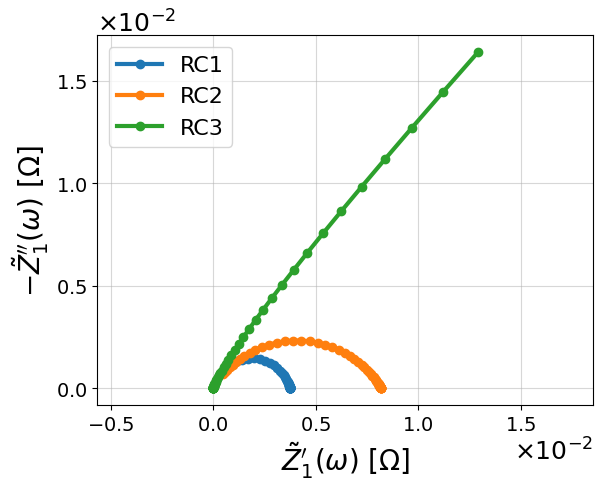

In [16]:
EIS_vis(p1_f_30p,f30)

###  50%

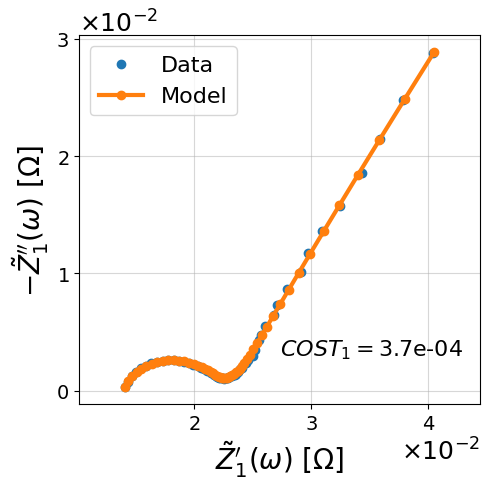

--- 0 mins 2.38 seconds ---


In [17]:
start_time = time.time()

### initialize the EIS and NLEIS string
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.001;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_f_50p,p1_f_50p,conf_f_50p = EIS(ax,Z1_f50,f50,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))



In [18]:
table(p1_f_50p,'Parameters Set')

Parameters Set
         L0         R0         R1       C1        Q1
-----------  ---------  ---------  -------  --------
1.63401e-07  0.0120042  0.0108572  1.09095  0.605794
         R2       C2    Q2
-----------  -------  ----
0.000447277  380.874     1
         R3      Aw        t       C3        Q3
-----------  ------  -------  -------  --------
2.26617e-13  2.6306  15312.7  261.049  0.718076


In [19]:
R(p1_f_50p)

0.011304480363857117

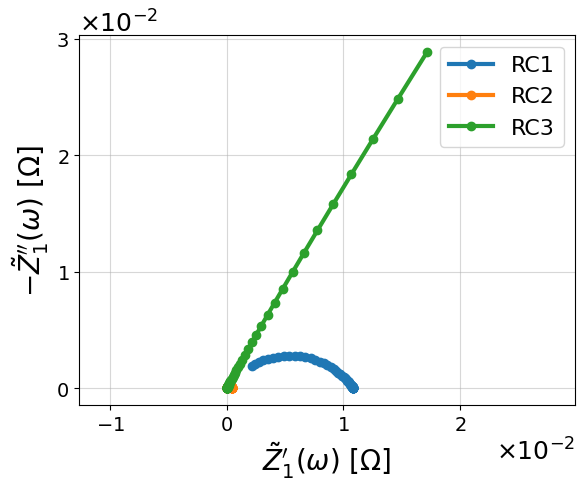

In [20]:
EIS_vis(p1_f_50p,f50)

# 300 cycle Cell

In [21]:
i= 1
f_300=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_freq.txt').view(float)

## 10%
Z1_300_10=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_10_.txt').view(complex)
Z2_300_10=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_10_.txt').view(complex)
mask =Z1_300_10.imag<0
f300_10 = f_300[mask]
Z1_300_10 =  Z1_300_10[mask]
Z2_300_10 =  Z2_300_10[mask]

## 30%
Z1_300_30=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_30_.txt').view(complex)
Z2_300_30=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_30_.txt').view(complex)
mask =Z1_300_30.imag<0
f300_30 = f_300[mask]

Z1_300_30 =  Z1_300_30[mask]
Z2_300_30 =  Z2_300_30[mask]

## 50%
Z1_300_50=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_50_.txt').view(complex)
Z2_300_50=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_50_.txt').view(complex)
mask =Z1_300_50.imag<0
f300_50 = f_300[mask]

Z1_300_50 =  Z1_300_50[mask]
Z2_300_50 =  Z2_300_50[mask]

## Curve Fitting 

### 10%

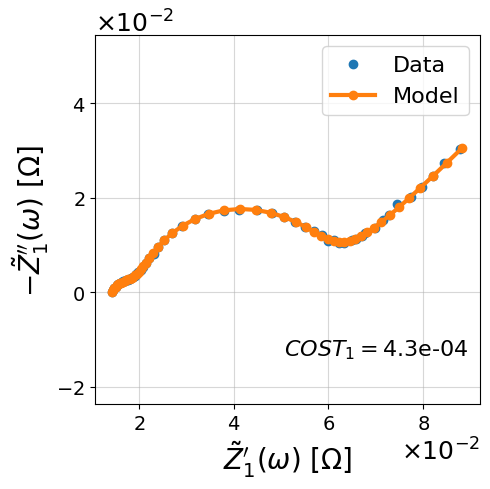

--- 0 mins 11.88 seconds ---


In [22]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.001;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_300_10p,p1_300_10p,conf_300_10p = EIS(ax,Z1_300_10,f300_10,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [23]:
table(p1_300_10p,'Parameters Set')

Parameters Set
         L0         R0         R1       C1        Q1
-----------  ---------  ---------  -------  --------
1.76355e-07  0.0123056  0.0227285  4.91843  0.897677
        R2       C2        Q2
----------  -------  --------
0.00950488  3.04581  0.521462
       R3        Aw        t       C3    Q3
---------  --------  -------  -------  ----
0.0145862  0.788938  10914.3  9.88959     1


In [24]:
R(p1_300_10p)

0.046819618253051726

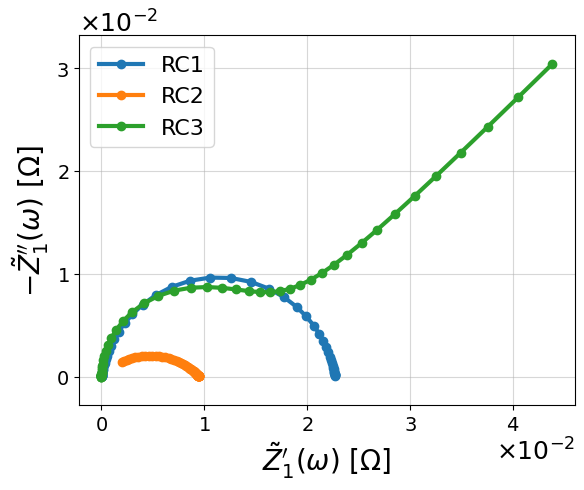

In [25]:
EIS_vis(p1_300_10p,f300_10)

### 30%

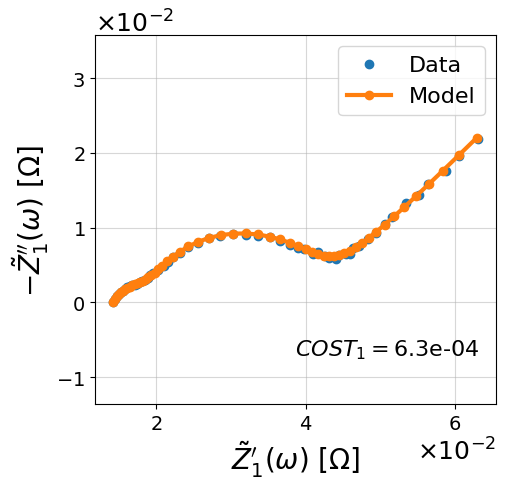

--- 0 mins 1.26 seconds ---


In [26]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode

circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.001;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_300_30p,p1_300_30p,conf_300_30p  = EIS(ax,Z1_300_30,f300_30,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [27]:
table(p1_300_30p,'Parameters Set')

Parameters Set
         L0         R0        R1       C1        Q1
-----------  ---------  --------  -------  --------
1.81094e-07  0.0120306  0.012921  4.89159  0.894947
       R2      C2        Q2
---------  ------  --------
0.0097378  3.7164  0.488907
        R3        Aw        t       C3    Q3
----------  --------  -------  -------  ----
0.00710514  0.990543  32782.8  15.5262     1


In [28]:
R(p1_300_30p)

0.02976397559063314

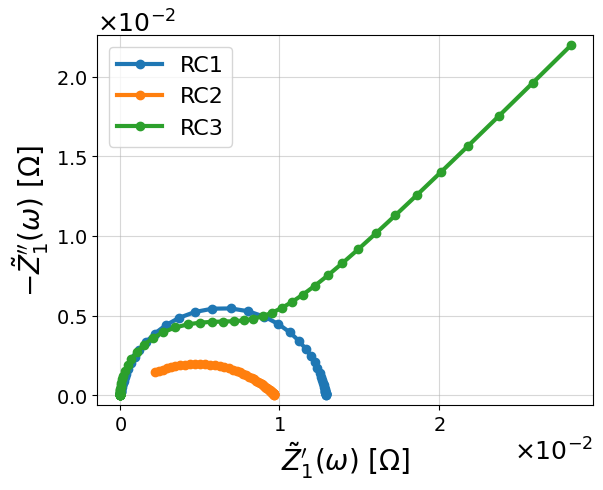

In [29]:
EIS_vis(p1_300_30p,f300_30)

###  50%

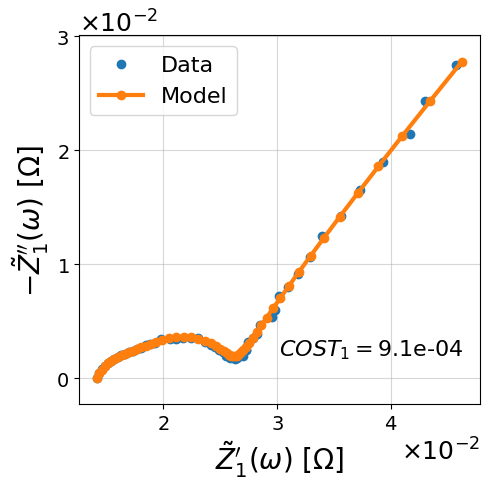

--- 2 mins 34.6 seconds ---


In [30]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.001;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_300_50p,p1_300_50p, conf_300_50p  = EIS(ax,Z1_300_50,f300_50,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [31]:
table(p1_300_50p,'Parameters Set')

Parameters Set
         L0        R0          R1       C1        Q1
-----------  --------  ----------  -------  --------
1.61879e-07  0.012883  0.00699959  3.67732  0.858149
        R2      C2        Q2
----------  ------  --------
0.00622984  1.7659  0.620166
         R3      Aw      t     C3        Q3
-----------  ------  -----  -----  --------
1.99034e-24  1.3338  22337  161.2  0.802898


In [32]:
R(p1_300_50p)

0.013229429462792593

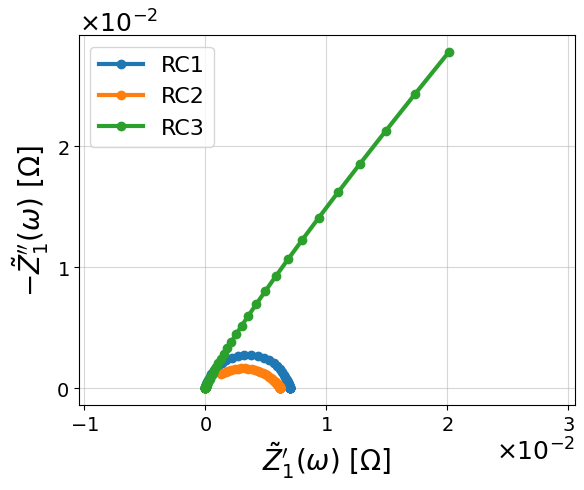

In [33]:
EIS_vis(p1_300_50p,f300_50)

# 600 cycle Cell

In [34]:
i= 50
f_600=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_freq.txt').view(float)

## 10%
Z1_600_10=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_10_.txt').view(complex)
Z2_600_10=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_10_.txt').view(complex)
mask =Z1_600_10.imag<0
f600_10 = f_600[mask]
Z1_600_10 =  Z1_600_10[mask]
Z2_600_10 =  Z2_600_10[mask]

## 30%
Z1_600_30=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_30_.txt').view(complex)
Z2_600_30=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_30_.txt').view(complex)
mask =Z1_600_30.imag<0
f600_30 = f_600[mask]

Z1_600_30 =  Z1_600_30[mask]
Z2_600_30 =  Z2_600_30[mask]

## 50%
Z1_600_50=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_50_.txt').view(complex)
Z2_600_50=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_50_.txt').view(complex)
mask =Z1_600_50.imag<0
f600_50 = f_600[mask]

Z1_600_50 =  Z1_600_50[mask]
Z2_600_50 =  Z2_600_50[mask]

## Curve Fitting 

### 10%

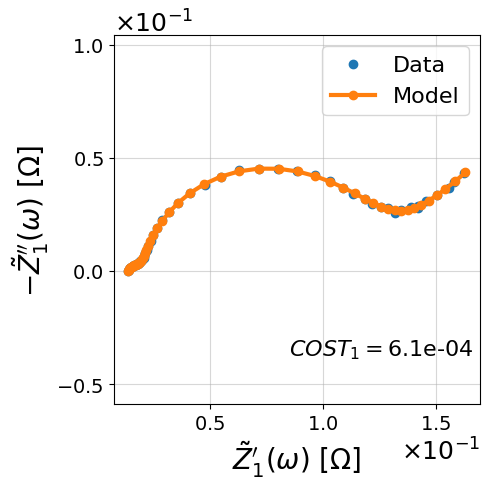

--- 0 mins 3.11 seconds ---


In [35]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.001;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_600_10p,p1_600_10p,conf_600_10p = EIS(ax,Z1_600_10,f600_10,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [36]:
table(p1_600_10p,'Parameters Set')

Parameters Set
         L0        R0          R1       C1        Q1
-----------  --------  ----------  -------  --------
1.63683e-07  0.012722  0.00795601  1.95849  0.610951
       R2       C2        Q2
---------  -------  --------
0.0111769  83.9377  0.809902
       R3      Aw        t      C3       Q3
---------  ------  -------  ------  -------
0.0926454  1.2205  14220.9  3.4733  0.90345


In [37]:
R(p1_600_10p)

0.11177824675764383

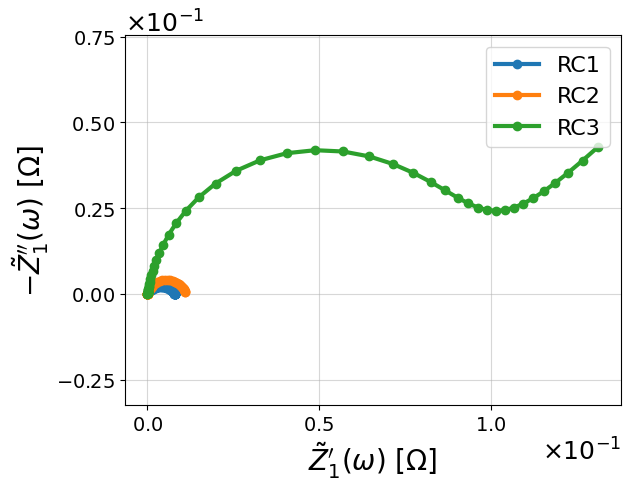

In [38]:
EIS_vis(p1_600_10p,f600_10)

### 30%

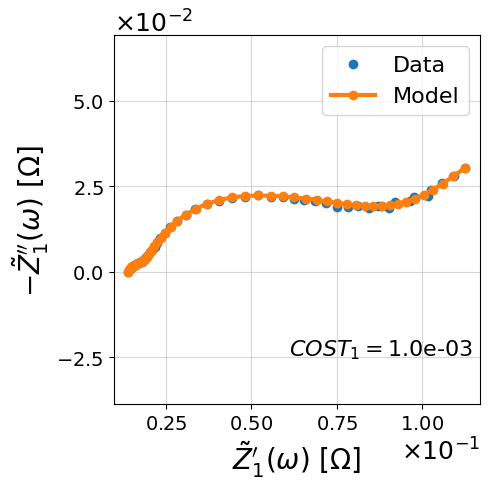

--- 0 mins 0.74 seconds ---


In [39]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.001;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_600_30p,p1_600_30p,conf_600_30p = EIS(ax,Z1_600_30,f600_30,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [40]:
table(p1_600_30p,'Parameters Set')

Parameters Set
       L0         R0         R1       C1        Q1
---------  ---------  ---------  -------  --------
1.618e-07  0.0128291  0.0196804  6.81888  0.938473
        R2       C2       Q2
----------  -------  -------
0.00554618  1.37777  0.66868
       R3        Aw        t      C3        Q3
---------  --------  -------  ------  --------
0.0548332  0.691879  10007.8  12.107  0.665459


In [41]:
R(p1_600_30p)

0.08005977942175078

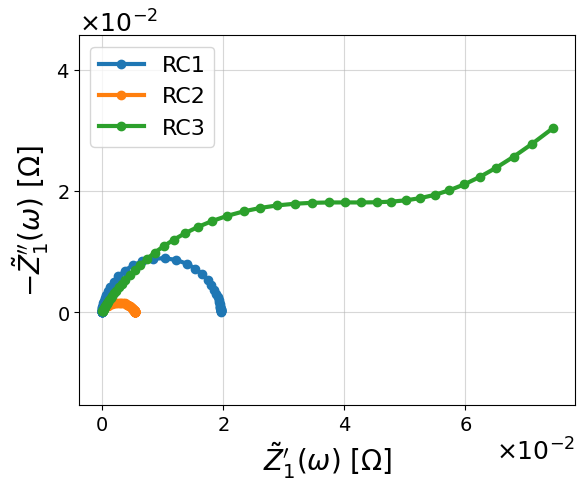

In [42]:
EIS_vis(p1_600_30p,f600_30)

###  50%

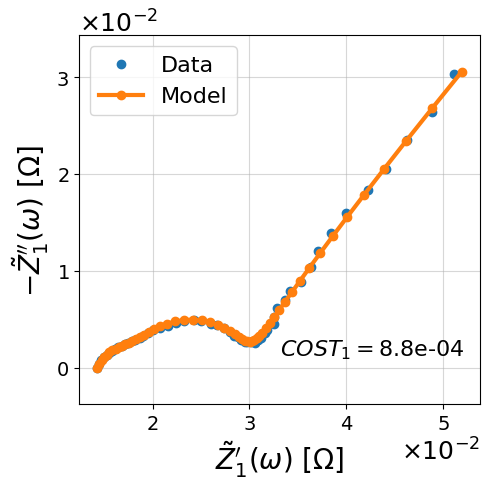

--- 0 mins 0.6 seconds ---


In [43]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.001;C2 = 2;Q2=1;
R3 = 0;C3 = 100;Q3 =1;
Aw = 1; t = 1000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_600_50p,p1_600_50p,conf_600_50p = EIS(ax,Z1_600_50,f600_50,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))



In [44]:
table(p1_600_50p,'Parameters Set')

Parameters Set
        L0         R0         R1      C1        Q1
----------  ---------  ---------  ------  --------
1.7636e-07  0.0129106  0.0106292  3.4199  0.850736
        R2      C2       Q2
----------  ------  -------
0.00630306  1.5884  0.62827
         R3        Aw        t       C3        Q3
-----------  --------  -------  -------  --------
7.80213e-35  0.929707  9085.25  147.653  0.808038


In [45]:
R(p1_600_50p)

0.016932279109091453

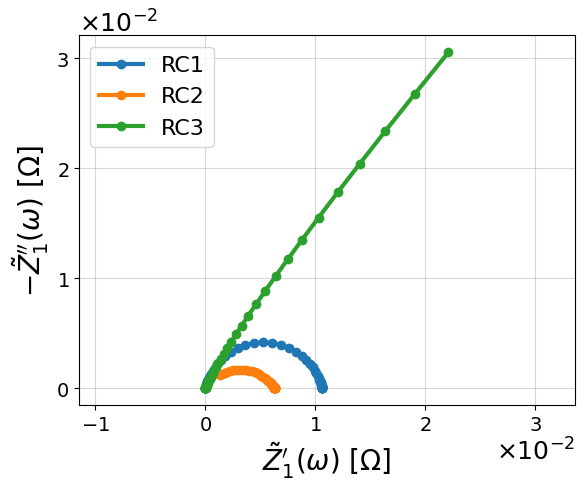

In [46]:
EIS_vis(p1_600_50p,f600_50)

# 900 cycle Cell

In [47]:
i= 6
f_900=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_freq.txt').view(float)

## 10%
Z1_900_10=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_10_.txt').view(complex)
Z2_900_10=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_10_.txt').view(complex)
mask =Z1_900_10.imag<0
f900_10 = f_900[mask]
Z1_900_10 =  Z1_900_10[mask]
Z2_900_10 =  Z2_900_10[mask]

## 30%
Z1_900_30=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_30_.txt').view(complex)
Z2_900_30=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_30_.txt').view(complex)
mask =Z1_900_30.imag<0
f900_30 = f_900[mask]

Z1_900_30 =  Z1_900_30[mask]
Z2_900_30 =  Z2_900_30[mask]

## 50%
Z1_900_50=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_50_.txt').view(complex)
Z2_900_50=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_50_.txt').view(complex)
mask =Z1_900_50.imag<0
f900_50 = f_900[mask]

Z1_900_50 =  Z1_900_50[mask]
Z2_900_50 =  Z2_900_50[mask]

## Curve Fitting 

### 10%

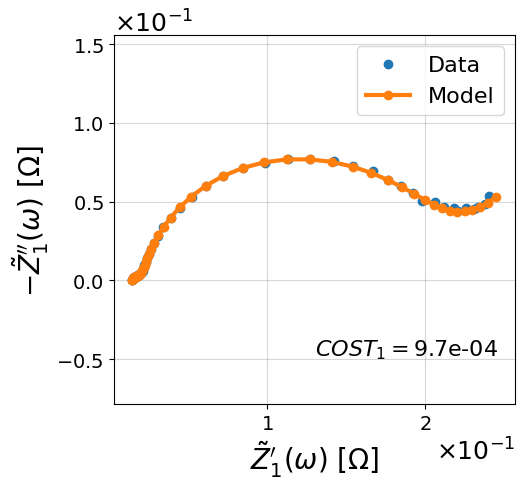

--- 0 mins 1.92 seconds ---


In [48]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.001;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_900_10p,p1_900_10p,conf_900_10p = EIS(ax,Z1_900_10,f900_10,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [49]:
table(p1_900_10p,'Parameters Set')

Parameters Set
         L0         R0        R1       C1        Q1
-----------  ---------  --------  -------  --------
1.69499e-07  0.0126597  0.008193  2.09934  0.592306
      R2      C2        Q2
--------  ------  --------
0.140532  3.8648  0.873005
       R3       Aw        t       C3    Q3
---------  -------  -------  -------  ----
0.0464761  1.16714  10691.6  24.4682     1


In [50]:
R(p1_900_10p)

0.19520071708945214

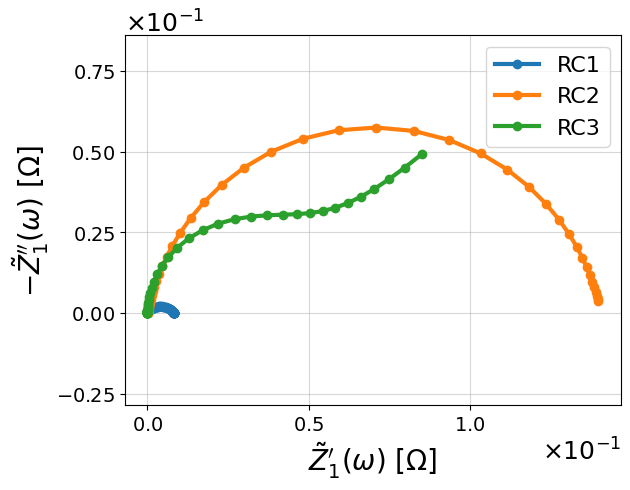

In [51]:
EIS_vis(p1_900_10p,f900_10)

### 30%

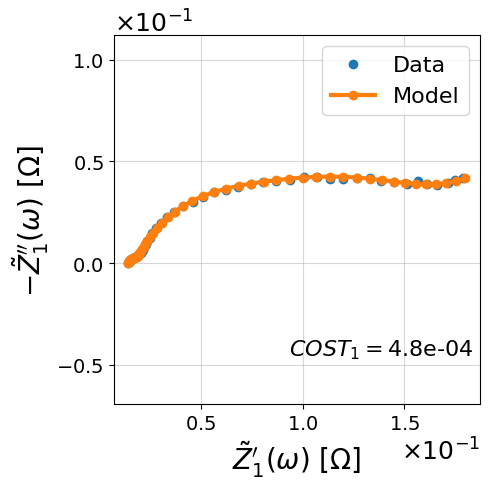

--- 0 mins 0.44 seconds ---


In [52]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.001;C1 = 1;Q1 = 1;
R2 = 0.01;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_900_30p,p1_900_30p,conf_900_30p = EIS(ax,Z1_900_30,f900_30,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [53]:
table(p1_900_30p,'Parameters Set')

Parameters Set
         L0         R0          R1        C1        Q1
-----------  ---------  ----------  --------  --------
1.47097e-07  0.0133351  0.00547811  0.974089  0.727389
       R2       C2       Q2
---------  -------  -------
0.0516776  5.72132  0.82342
       R3        Aw        t       C3        Q3
---------  --------  -------  -------  --------
0.0991064  0.731507  10082.9  17.8626  0.732855


In [54]:
R(p1_900_30p)

0.15626213109211884

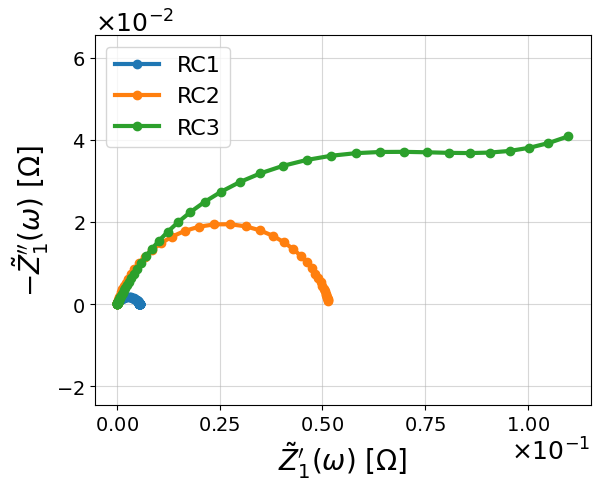

In [55]:
EIS_vis(p1_900_30p,f900_30)

###  50%

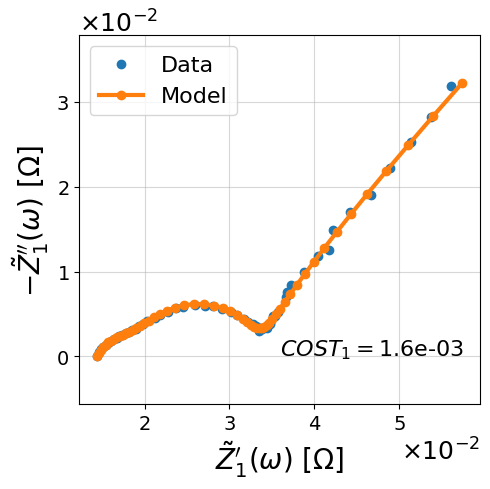

--- 0 mins 0.67 seconds ---


In [56]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.01;C2 = 2;Q2=1;
R3 = 0.01;C3 = 10;Q3 =1;
Aw = 1; t = 10000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_900_50p,p1_900_50p,conf_900_50p = EIS(ax,Z1_900_50,f900_50,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))



In [57]:
table(p1_900_50p,'Parameters Set')

Parameters Set
         L0         R0          R1       C1        Q1
-----------  ---------  ----------  -------  --------
1.74211e-07  0.0128288  0.00808608  2.44663  0.566288
       R2      C2        Q2
---------  ------  --------
0.0127863  3.6422  0.869924
         R3        Aw        t      C3        Q3
-----------  --------  -------  ------  --------
2.68293e-25  0.856841  9343.22  147.93  0.924258


In [58]:
R(p1_900_50p)

0.02087241206874313

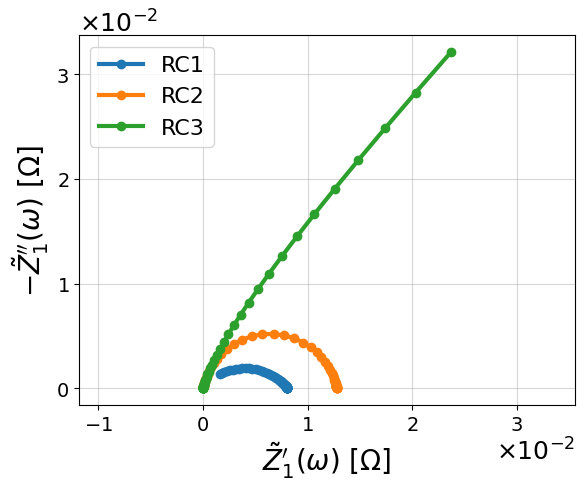

In [59]:
EIS_vis(p1_900_50p,f900_50)

# 1500 cycle Cell

In [60]:
i= 11

f_1500=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_freq.txt').view(float)

## 10%
Z1_1500_10=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_10_.txt').view(complex)
Z2_1500_10=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_10_.txt').view(complex)
mask =Z1_1500_10.imag<0
f1500_10 = f_1500[mask]
Z1_1500_10 =  Z1_1500_10[mask]
Z2_1500_10 =  Z2_1500_10[mask]

## 30%
Z1_1500_30=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_30_.txt').view(complex)
Z2_1500_30=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_30_.txt').view(complex)
mask =Z1_1500_30.imag<0
f1500_30 = f_1500[mask]

Z1_1500_30 =  Z1_1500_30[mask]
Z2_1500_30 =  Z2_1500_30[mask]

## 50%
Z1_1500_50=np.loadtxt(path+'EIS_processed/Cell'+str(i)+'/Cell'+str(i)+'_Z1s_50_.txt').view(complex)
Z2_1500_50=np.loadtxt(path+'NLEIS_worked_up_data/Cell'+str(i)+'/Cell'+str(i)+'_Z2s_50_.txt').view(complex)
mask =Z1_1500_50.imag<0
f1500_50 = f_1500[mask]

Z1_1500_50 =  Z1_1500_50[mask]
Z2_1500_50 =  Z2_1500_50[mask]

## Curve Fitting 

### 10%

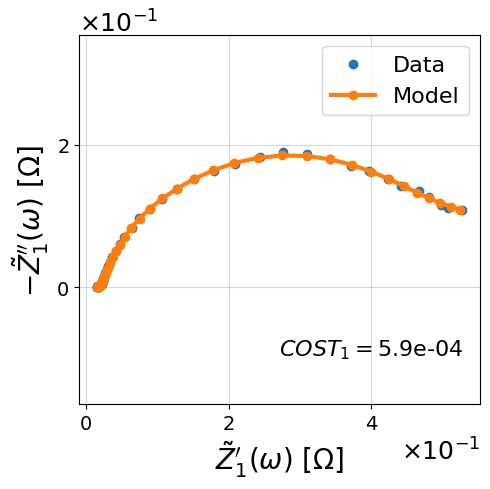

--- 0 mins 1.11 seconds ---


In [61]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

# L0 =1e-8;R0 = 0.01;
# R1 = 0.01;C1 = 1;Q1 = 0.9;
# R2 = 0.01;C2 = 2;Q2= 0.9;
# R3 = 0.01;C3 = 10;Q3 = 0.9;
# Aw = 1; t = 10000

L0 =1e-8;R0 = 0.01;
R1 = 0.001;C1 = 1;Q1 = 1;
R2 = 0.01;C2 = 2;Q2= 1;
R3 = 0.01;C3 = 10;Q3 = 1;
Aw = 1; t = 10000
# L0 =1e-8;R0 = 0.01;
# R1 = 0;C1 = 1;Q1 = 1;
# R2 = 0.01;C2 = 2;Q2= 1;
# R3 = 0.01;C3 = 10;Q3 = 1;
# Aw = 1; t = 10000
initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_1500_10p,p1_1500_10p,conf_1500_10p = EIS(ax,Z1_1500_10,f1500_10,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [62]:
table(p1_1500_10p,'Parameters Set')

Parameters Set
          L0         R0        R1       C1        Q1
------------  ---------  --------  -------  --------
2.23724e-264  0.0168336  0.265376  20.9594  0.461006
       R2       C2    Q2
---------  -------  ----
0.0506341  11.8263     1
      R3        Aw        t       C3        Q3
--------  --------  -------  -------  --------
0.325799  0.581232  10040.8  7.06906  0.894712


In [63]:
R(p1_1500_10p)

0.641808792279821

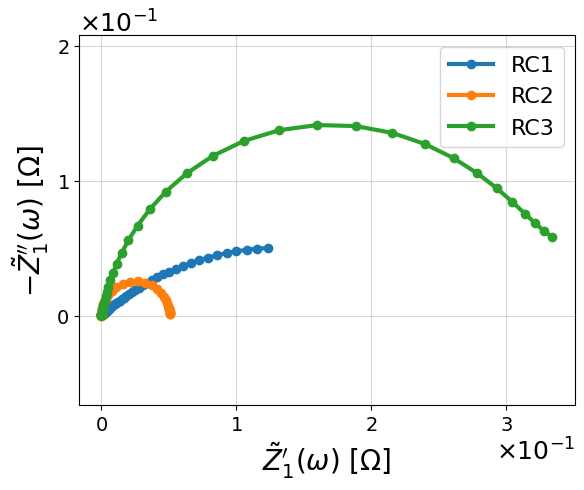

In [64]:
EIS_vis(p1_1500_10p,f1500_10)

### 30%

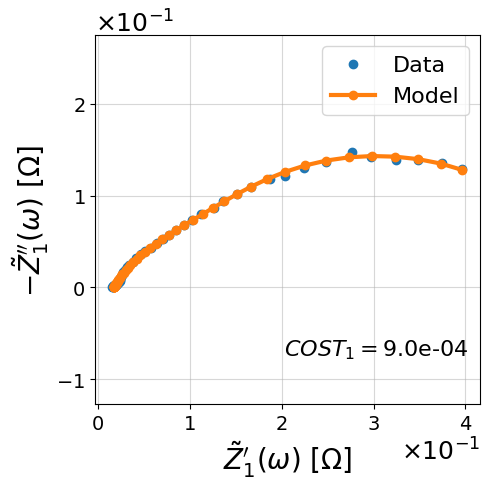

--- 0 mins 1.4 seconds ---


In [65]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string
# circ_str_1 = 'L0-R0-p(R1,C1)-p(R2,C2)-p(R3-Wo1,C3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.001;C1 = 10;Q1 = 1;
R2 = 0.01;C2 = 50;Q2= 1;
R3 = 0.01;C3 = 100;Q3 = 1;
Aw = 1; t = 1000

# L0 =1e-8;R0 = 0.01;
# R1 = 0;C1 = 10;Q1 = 1;
# R2 = 0.01;C2 = 50;Q2= 1;
# R3 = 0.01;C3 = 100;Q3 = 1;
# Aw = 1; t = 1000
initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])

# initial_guess = np.array([L0,R0,R1,C1,R2,C2,R3,Aw,t,C3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_1500_30p,p1_1500_30p,conf_1500_30p = EIS(ax,Z1_1500_30,f1500_30,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))


In [66]:
table(p1_1500_30p,'Parameters Set')

Parameters Set
          L0         R0        R1       C1        Q1
------------  ---------  --------  -------  --------
4.94066e-324  0.0172724  0.123443  6.68299  0.655883
      R2      C2        Q2
--------  ------  --------
0.276419  23.587  0.817326
       R3           Aw       t       C3        Q3
---------  -----------  ------  -------  --------
0.0908675  4.98494e-09  292986  415.728  0.999991


In [67]:
R(p1_1500_30p)

0.49072901515277867

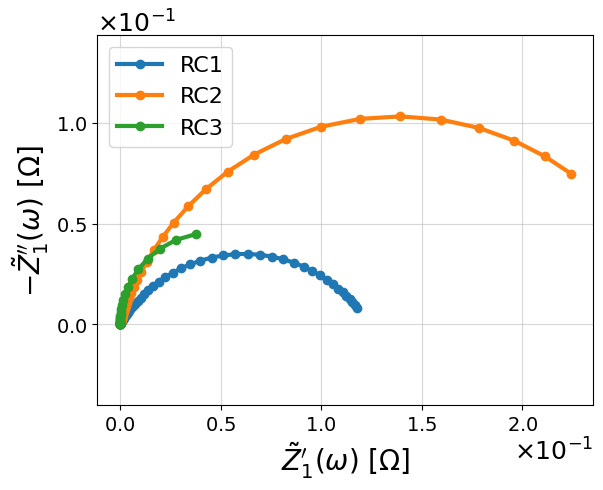

In [68]:
EIS_vis(p1_1500_30p,f1500_30)

###  50%

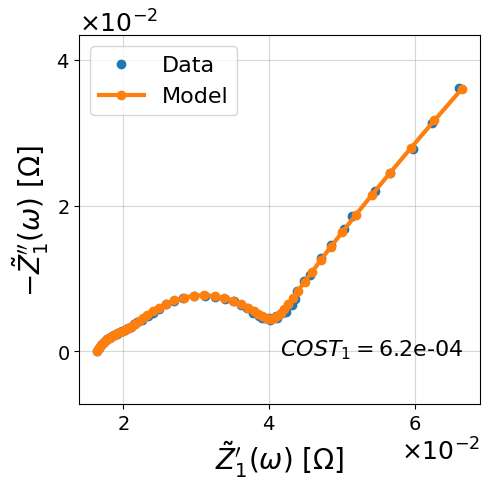

--- 0 mins 0.54 seconds ---


In [69]:
start_time = time.time()

### initialize the EIS and NLEIS string
### inductor in series with a resistor, a spherical cathode, and a planar anode
circ_str_1 = 'L0-R0-p(R1,CPE1)-p(R2,CPE2)-p(R3-Wo1,CPE3)' ## EIS string

L0 =1e-8;R0 = 0.01;
R1 = 0.01;C1 = 1;Q1 = 1;
R2 = 0.001;C2 = 2;Q2=1;
R3 = 0;C3 = 100;Q3 =1;
Aw = 1; t = 1000

initial_guess = np.array([L0,R0,R1,C1,Q1,R2,C2,Q2,R3,Aw,t,C3,Q3])
fig,ax = plt.subplots(figsize=(5,5))

Z1_fit_1500_50p,p1_1500_50p,conf_1500_50p = EIS(ax,Z1_1500_50,f1500_50,initial_guess,circ_str_1
                       ,bounds = None)

plt.tight_layout()
plt.show()
total_time = time.time() - start_time
print("--- %s mins " % int(total_time/60)+'%s seconds ---' % round(np.mod(total_time,60),2))



In [70]:
table(p1_1500_50p,'Parameters Set')

Parameters Set
         L0         R0         R1      C1        Q1
-----------  ---------  ---------  ------  --------
1.99496e-07  0.0142933  0.0171312  3.8464  0.841713
        R2       C2        Q2
----------  -------  --------
0.00895764  2.90813  0.516173
         R3        Aw        t       C3        Q3
-----------  --------  -------  -------  --------
4.42724e-07  0.830126  6899.57  138.842  0.923652


In [71]:
R(p1_1500_50p)

0.026089253313678253

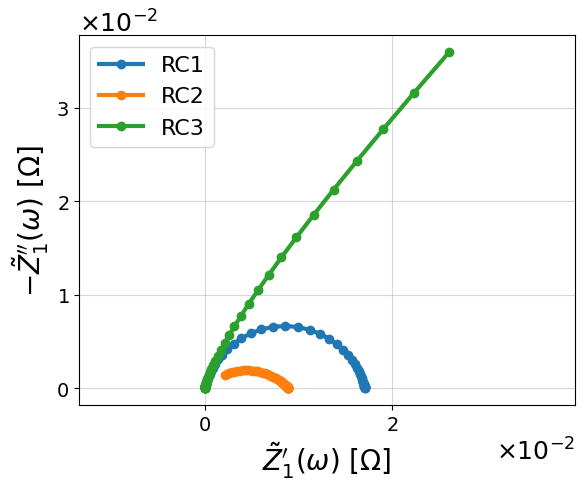

In [72]:
EIS_vis(p1_1500_50p,f1500_50)

# Parameter Extraction

In [73]:
R(p1_1500_50p)
df10 = pd.DataFrame()
df10['cycle']=[0, 300, 600, 900, 1500]
df10['R']=[R(p1_f_10p),R(p1_300_10p),R(p1_600_10p),R(p1_900_10p),R(p1_1500_10p)]
df10['std']=[sigma(conf_f_10p),sigma(conf_300_10p),sigma(conf_600_10p),sigma(conf_900_10p),sigma(conf_1500_10p)]

df30 = pd.DataFrame()
df30['cycle']=[0, 300, 600, 900, 1500]
df30['R']=[R(p1_f_30p),R(p1_300_30p),R(p1_600_30p),R(p1_900_30p),R(p1_1500_30p)]
df30['std']=[sigma(conf_f_30p),sigma(conf_300_30p),sigma(conf_600_30p),sigma(conf_900_30p),sigma(conf_1500_30p)]

df50 = pd.DataFrame()
df50['cycle']=[0, 300, 600, 900, 1500]
df50['R']=[R(p1_f_50p),R(p1_300_50p),R(p1_600_50p),R(p1_900_50p),R(p1_1500_50p)]
df50['std']=[sigma(conf_f_50p),sigma(conf_300_50p),sigma(conf_600_50p),sigma(conf_900_50p),sigma(conf_1500_50p)]


In [74]:
stats_path = path+'raw_cycling_data_stats/'
data_path = path+'raw_cycling_data/'

In [75]:
files = glob.glob(stats_path+'**/*.csv',  
                   recursive = True) 

In [76]:
cells_300 = [1,2,3,4]
files_300 = [file for file in files if any(f'Cell{cell} -' in file for cell in cells_300)]
cells_600 = [49,50]
files_600 = [file for file in files if any(f'Cell{cell} -' in file for cell in cells_600)]
cells_900 = [5,6,7,8]
files_900 = [file for file in files if any(f'Cell{cell} -' in file for cell in cells_900)]
cells_1500 = [9,10,11,12]
files_1500 = [file for file in files if any(f'Cell{cell} -' in file for cell in cells_1500)]

In [77]:
file_name_group = [files_300,files_600,files_900,files_1500]

In [78]:
ms = 7

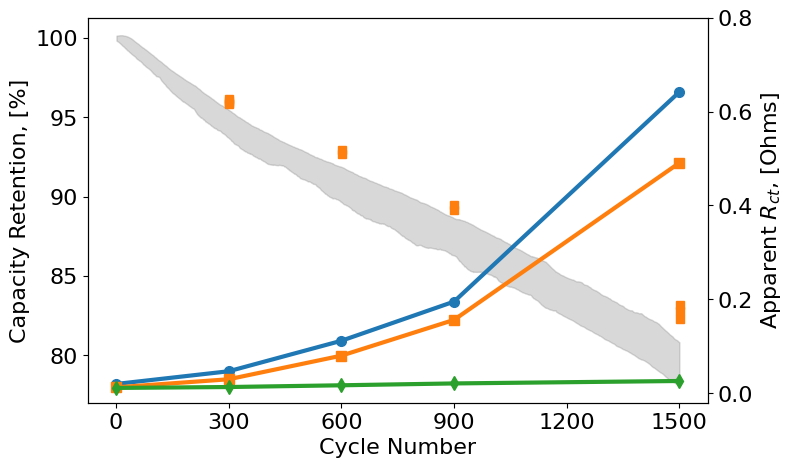

In [79]:
fig,ax = plt.subplots(figsize = (8,5))
fontsize = 16


for group in file_name_group[::-1]:
    for file in group:
        df = pd.read_csv(file)
        df1 = df[(1<=df['Cycle'])&(df['Cycle']<df['Cycle'].max())]

        plt.plot(df['Cycle'].iloc[-1],100*df['AH-OUT'].iloc[-1]/df['AH-OUT'].iloc[0],color = 'C1',marker ='s')

y = []
for file in files_1500:

    df = df = pd.read_csv(file)
    df1 = df[(1<=df['Cycle'])&(df['Cycle']<df['Cycle'].max())]
    ret = df1['AH-OUT']/df1['AH-OUT'].iloc[0]
    ret_smoothed = savgol_filter(ret, 100, 2, mode='nearest')
    cycle = df1['Cycle'].to_numpy()
    if file == files_1500[0]:
        slope, intercept, _, _, _ = linregress(cycle[cycle>1000], ret_smoothed[cycle>1000])
        x = np.arange(1172, 1501, 1)
        ret_extended = intercept + slope * x
        ret_smoothed = np.concatenate((ret_smoothed, ret_extended))
    y.append(ret_smoothed)
y = np.column_stack(y)
y_mean = np.nanmean(y, axis=1)
y_std = np.nanstd(y, axis=1)
x1 = np.arange(1,1501,1)

plt.fill_between(x1, 100*(y_mean - 2*y_std), 100*(y_mean + 2*y_std), color='gray', alpha=0.3)
# plt.fill_between(df1['Cycle'], 100*(y_mean - 6*y_std), 100*(y_mean + 3*y_std), color='gray', alpha=0.2)

# plt.legend(handles[::-1],['300 Cycles','600 Cycles','900 Cycles','1500 Cycles'],fontsize = fontsize)
plt.ylabel('Capacity Retention, [%]', fontsize = fontsize)

plt.xlabel('Cycle Number', fontsize = fontsize)
plt.xticks(np.linspace(0,1500,6),fontsize = fontsize)
plt.yticks(fontsize = fontsize)

ax2 = ax.twinx()

plt.plot(df10['cycle'] ,df10['R'],'-o',lw=3, ms = ms)
plt.plot(df30['cycle'] ,df30['R'],'-s',lw=3, ms = ms)
plt.plot(df50['cycle'] ,df50['R'],'-d',lw=3, ms = ms)

plt.yticks(fontsize = fontsize)
plt.ylabel('Apparent $R_{ct} $, [Ohms]',fontsize = fontsize)
plt.yticks(np.arange(0,0.9,0.2),fontsize = fontsize)

plt.show()
# fig.savefig('figures/Aging_data_with_resistance.png',dpi=300,bbox_inches='tight')

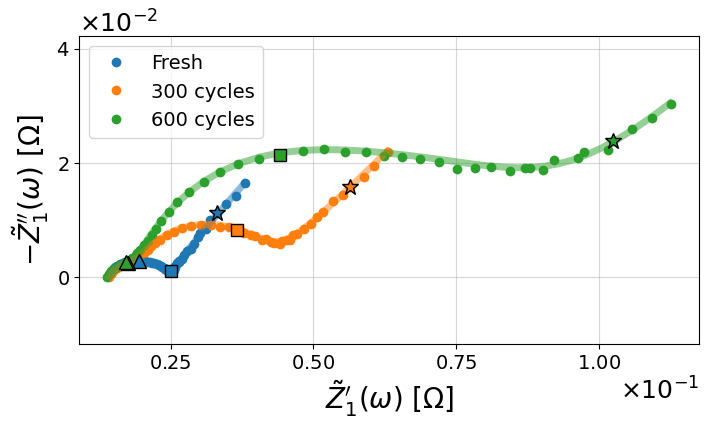

In [81]:
fig, ax = plt.subplots(figsize=(8,4))
plot_first(ax, Z1_f30,fmt = 'o',color = 'C0')
plot_first(ax, Z1_300_30,fmt = 'o',color = 'C1')
plot_first(ax, Z1_600_30,fmt = 'o',color = 'C2')

plot_first(ax,Z1_fit_f_30p,fmt = '-',lw =5, alpha = 0.5, color = 'C0')
plot_first(ax,Z1_fit_300_30p,fmt = '-',lw =5, alpha = 0.5, color = 'C1')
plot_first(ax,Z1_fit_600_30p,fmt = '-',lw =5, alpha = 0.5, color = 'C2')

# plot_first(ax, Z1_900_30,fmt = 'o',color = 'C5')

plot_first(ax, Z1_f30[f30==100],fmt = '^',ms = 10,color = 'C0',markeredgecolor='k')
plot_first(ax, Z1_300_30[f300_30==100],fmt = '^',ms = 10,color = 'C1',markeredgecolor='k')
plot_first(ax, Z1_600_30[f600_30==100],fmt = '^',ms = 10,color = 'C2',markeredgecolor='k')
# plot_first(ax, Z1_900_30[f900_30==100],fmt = '^',ms = 10,color = 'C5',markeredgecolor='k')

ms = 8
plot_first(ax, Z1_f30[f30==1],fmt = 's',ms = ms,color = 'C0',markeredgecolor='k')
plot_first(ax, Z1_300_30[f300_30==1],fmt = 's',ms = ms,color = 'C1',markeredgecolor='k')
plot_first(ax, Z1_600_30[f600_30==1],fmt = 's',ms = ms,color = 'C2',markeredgecolor='k')
# plot_first(ax, Z1_900_30[f900_30==1],fmt = 's',ms = ms,color = 'C5',markeredgecolor='k')

plot_first(ax, Z1_f30[f30==0.01],fmt = '*',ms = 12,color = 'C0',markeredgecolor='k')
plot_first(ax, Z1_300_30[f300_30==0.01],fmt = '*',ms = 12,color = 'C1',markeredgecolor='k')
plot_first(ax, Z1_600_30[f600_30==0.01],fmt = '*',ms = 12,color = 'C2',markeredgecolor='k')
# plot_first(ax, Z1_900_30[f900_30==0.01],fmt = '*',ms = 12,color = 'C5',markeredgecolor='k')

# ax.legend(['Fresh','300 cycles','600 cycles','900 cycles'],fontsize=12,loc='upper left')
ax.legend(['Fresh','300 cycles','600 cycles'],fontsize=14,loc='upper left')
# ax.set_xlabel(r'$\tilde{Z}_{1}^{\prime}(\omega)$' +
#               r' [$\Omega$]', fontsize=fontsize)
# ax.set_ylabel(r'$-\tilde{Z}_{1}^{\prime\prime}(\omega)$' +
#               r' [$\Omega$]', fontsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)

# plt.ylim([0,0.05])
plt.show()
# fig.savefig('figures/30%_horizontal.png',dpi=300,bbox_inches='tight')

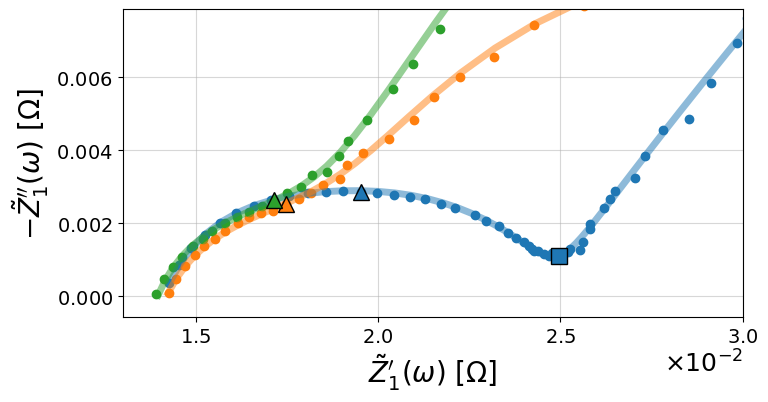

In [82]:
fig, ax = plt.subplots(figsize=(8,4))
plot_first(ax, Z1_f30,fmt = 'o',color = 'C0')
plot_first(ax, Z1_300_30,fmt = 'o',color = 'C1')
plot_first(ax, Z1_600_30,fmt = 'o',color = 'C2')
# plot_first(ax, Z1_900_30,fmt = 'o',color = 'C5')
plot_first(ax,Z1_fit_f_30p,fmt = '-',lw =5, alpha = 0.5, color = 'C0')
plot_first(ax,Z1_fit_300_30p,fmt = '-',lw =5, alpha = 0.5, color = 'C1')
plot_first(ax,Z1_fit_600_30p,fmt = '-',lw =5, alpha = 0.5, color = 'C2')

ms = 12
plot_first(ax, Z1_f30[f30==100],fmt = '^',ms = ms,color = 'C0',markeredgecolor='k')
plot_first(ax, Z1_300_30[f300_30==100],fmt = '^',ms = ms,color = 'C1',markeredgecolor='k')
plot_first(ax, Z1_600_30[f600_30==100],fmt = '^',ms = ms,color = 'C2',markeredgecolor='k')
# plot_first(ax, Z1_900_30[f900_30==100],fmt = '^',ms = ms,color = 'C5',markeredgecolor='k')
ms = 12
plot_first(ax, Z1_f30[f30==1],fmt = 's',ms = ms,color = 'C0',markeredgecolor='k')
plot_first(ax, Z1_300_30[f300_30==1],fmt = 's',ms = ms,color = 'C1',markeredgecolor='k')
plot_first(ax, Z1_600_30[f600_30==1],fmt = 's',ms = ms,color = 'C2',markeredgecolor='k')
# plot_first(ax, Z1_900_30[f900_30==1],fmt = 's',ms = ms,color = 'C5',markeredgecolor='k')

ax.set_xlim([1.3e-2,3e-2])
ax.set_ylim([-0.2e-3,0.75e-2])
# ax.set_xlabel(r'$\tilde{Z}_{1}^{\prime}(\omega)$' +
#               r' [$\Omega$]', fontsize=fontsize)
# ax.set_ylabel(r'$-\tilde{Z}_{1}^{\prime\prime}(\omega)$' +
#               r' [$\Omega$]', fontsize=fontsize)
# ax.tick_params(axis='both', which='major', labelsize=fontsize)

plt.show()
# fig.savefig('figures/30%_zoom.png',dpi=300,bbox_inches='tight')